In [1]:
from IPython import display

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar

In [3]:
schedule_names = ['fcfs', 'backfill']

In [4]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/backfill/base_backfill_schedule.csv', '../output/fcfs/base_fcfs_schedule.csv']
['../output/backfill/base_backfill_jobs.csv', '../output/fcfs/base_fcfs_jobs.csv']


In [5]:
metrics = pd.DataFrame()
for file in schedule_files:
    _, schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print("reading", file)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

reading ../output/backfill/base_backfill_schedule.csv
reading ../output/fcfs/base_fcfs_schedule.csv


In [6]:
jobsets = {}
for file in jobs_files:
    _, schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print("reading", file)
        jobsets[schedule_name] = JobSet.from_csv(file)

reading ../output/backfill/base_backfill_jobs.csv
reading ../output/fcfs/base_fcfs_jobs.csv


In [7]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [8]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [9]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [10]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [11]:
metrics.T

,fcfs,backfill
batsim_version,4.0.0,4.0.0
consumed_joules,0,0
makespan,259305,259305
max_slowdown,3889.79,3889.79
max_turnaround_time,8039.74,8039.74
max_waiting_time,8029.81,8029.81
mean_slowdown,82.9339,82.9339
mean_turnaround_time,761.942,761.942
mean_waiting_time,608.894,608.894
nb_computing_machines,4,4


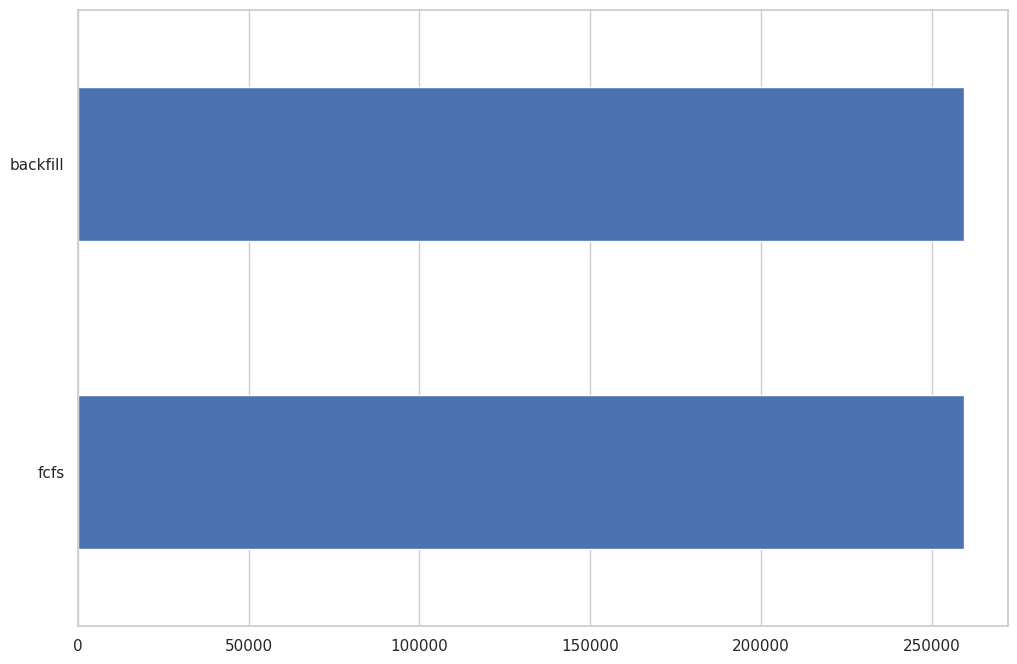

In [12]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

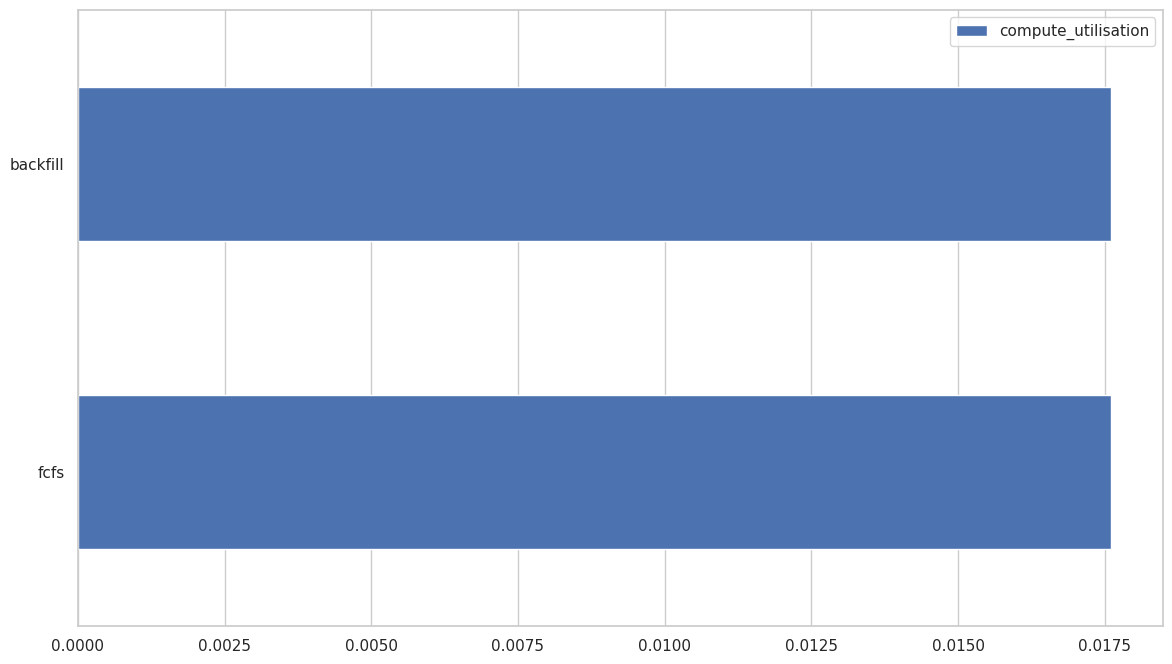

In [13]:
ax = metrics[['compute_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [14]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.500030,9.599638,1.054951
1,fcfs,10.101609,13.111804,4.355799
2,fcfs,13.613775,22.713383,2.496084
3,fcfs,23.215354,29.686545,4.587493
4,fcfs,0.500045,12.701379,1.040983
...,...,...,...,...
1444,backfill,1076.035651,1695.641906,2.736644
1445,backfill,73.697350,201.201975,1.577997
1446,backfill,201.703263,218.305240,13.149352
1447,backfill,218.807211,229.428439,21.600933


In [15]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,backfill
count,1449.000000,1449.000000
mean,608.894048,608.894048
std,925.455081,925.455081
min,0.500030,0.500030
25%,17.351654,17.351654
50%,110.668606,110.668606
75%,999.963513,999.963513
max,8029.814193,8029.814193


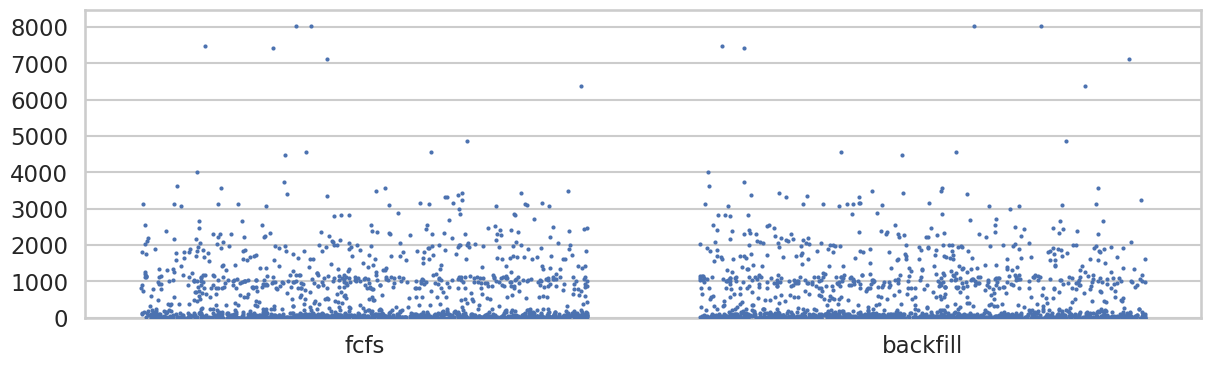

In [16]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

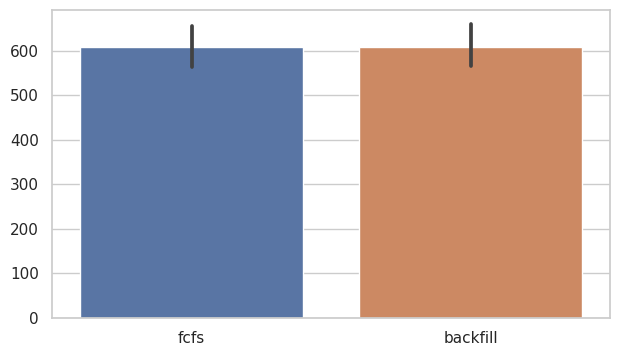

In [17]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

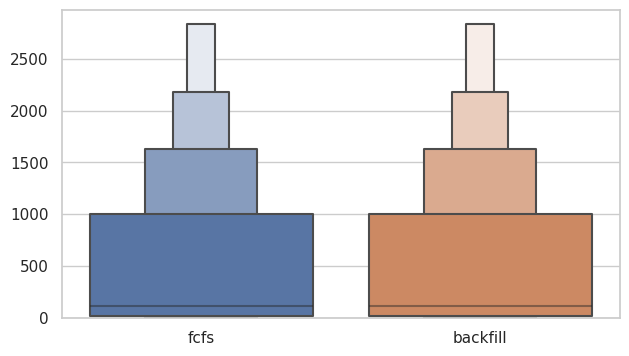

In [18]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

In [19]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,backfill
count,1449.000000,1449.000000
mean,761.942103,761.942103
std,1014.035304,1014.035304
min,0.666833,0.666833
25%,54.623115,54.623115
50%,209.901200,209.901200
75%,1124.667722,1124.667722
max,8039.739598,8039.739598


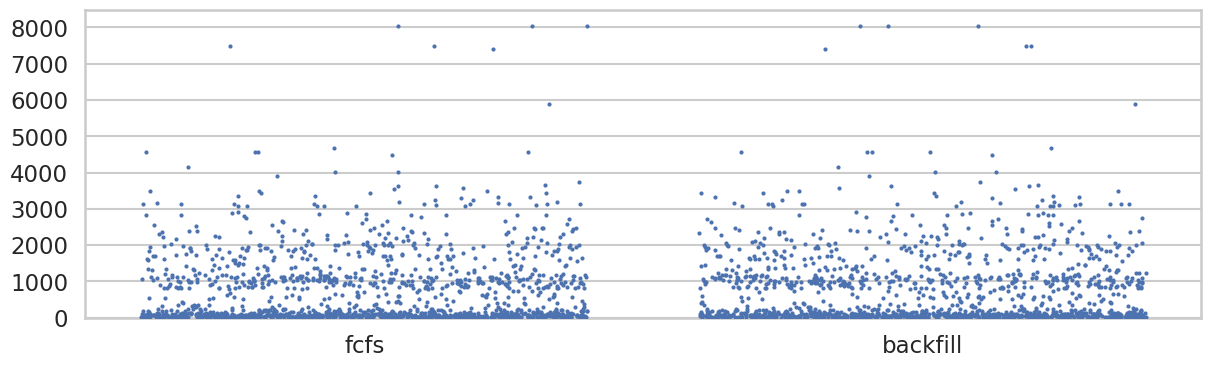

In [20]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

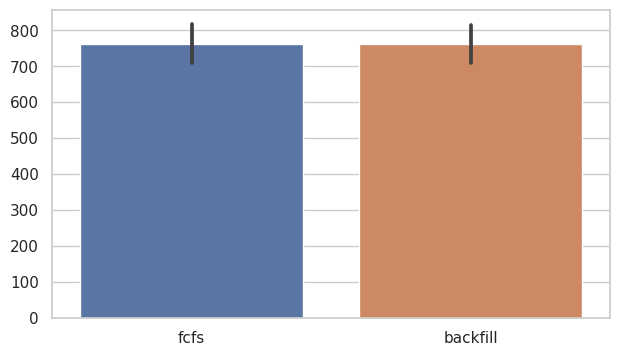

In [21]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

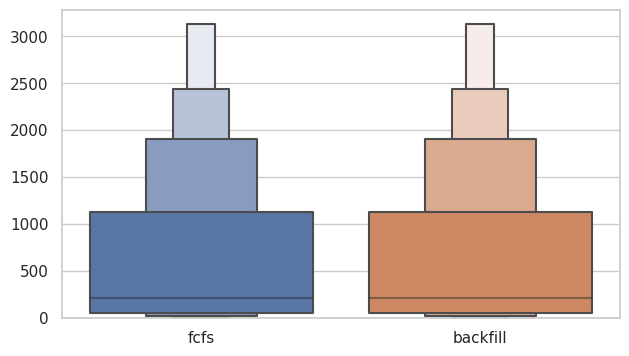

In [22]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

In [23]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,backfill
count,1449.000000,1449.000000
mean,82.933907,82.933907
std,254.732457,254.732457
min,1.000419,1.000419
25%,1.731098,1.731098
50%,6.178078,6.178078
75%,47.968159,47.968159
max,3889.788933,3889.788933


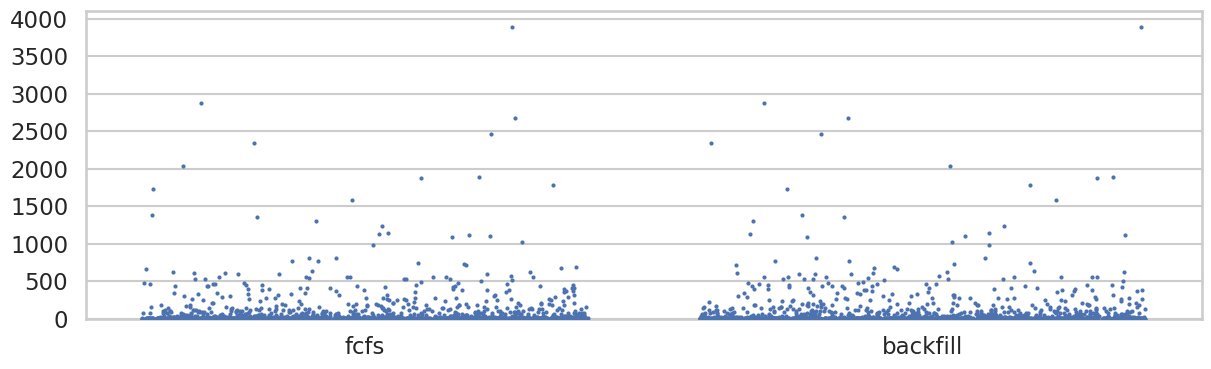

In [24]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

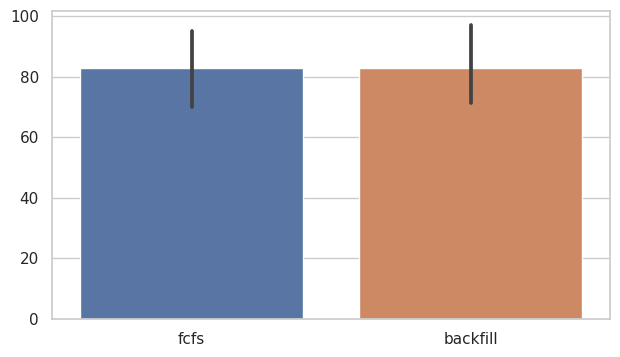

In [25]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

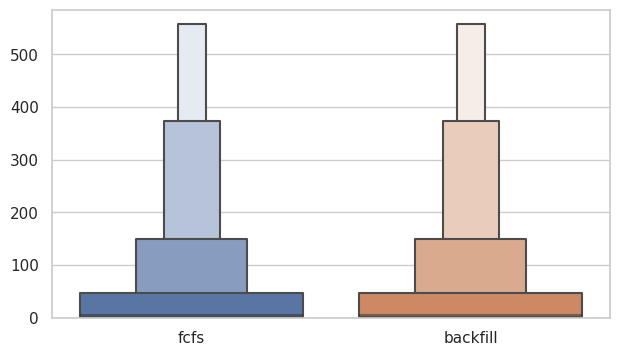

In [26]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

In [27]:
# FCFS

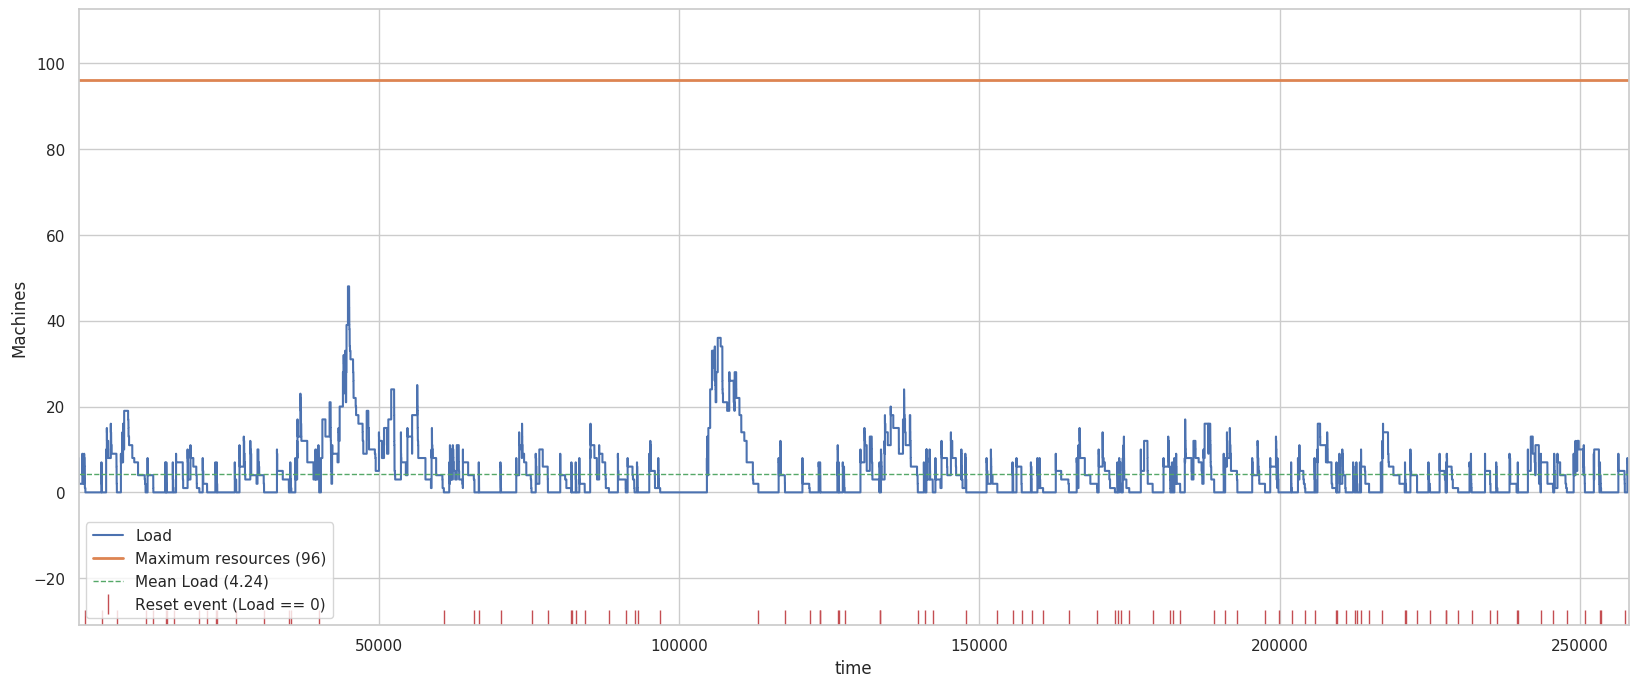

In [28]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

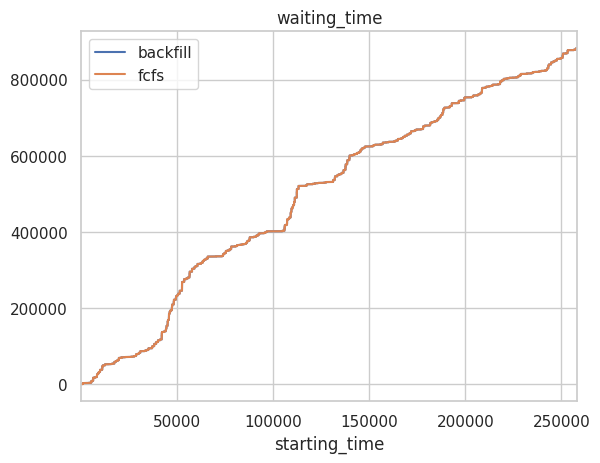

In [29]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)